In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from numpy import array 
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
import matplotlib.image as mpimg
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

(135000, 32, 32, 3)
[[[ 0.78823531  0.78039217  0.7764706 ]
  [ 0.80000001  0.79607844  0.79607844]
  [ 0.80392158  0.80000001  0.79607844]
  ..., 
  [ 0.80784315  0.79607844  0.79607844]
  [ 0.83529413  0.83137256  0.82745099]
  [ 0.8509804   0.85490197  0.8509804 ]]

 [[ 0.87843138  0.82745099  0.78039217]
  [ 0.90196079  0.89803922  0.86274511]
  [ 0.84313726  0.78039217  0.74901962]
  ..., 
  [ 0.40000001  0.34117648  0.33333334]
  [ 0.72549021  0.66274512  0.67058825]
  [ 0.98823529  0.96470588  0.93725491]]

 [[ 0.86274511  0.81568629  0.80784315]
  [ 0.87450981  0.88627452  0.83529413]
  [ 0.82745099  0.79215688  0.72549021]
  ..., 
  [ 0.22745098  0.17647059  0.16078432]
  [ 0.74509805  0.68627453  0.68627453]
  [ 0.95294118  0.94901961  0.89411765]]

 ..., 
 [[ 0.41568628  0.64313728  0.67843139]
  [ 0.41176471  0.65490198  0.7019608 ]
  [ 0.41960785  0.67058825  0.69803923]
  ..., 
  [ 0.43529412  0.63921571  0.60000002]
  [ 0.42745098  0.61176473  0.53725493]
  [ 0.41960785 

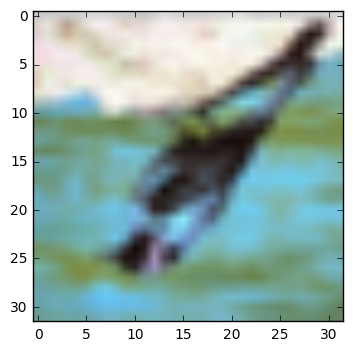

In [4]:
## test the pickle file still looks good after unpickle the file
pickle_file = 'cifar_10_04_type.pickle'
with open(pickle_file, 'rb') as f:
    dic = pickle.load(f)
    train_dataset = dic['train_dataset']
    train_labels = dic['train_labels']
    valid_dataset = dic['valid_dataset']
    valid_labels = dic['valid_labels']
    test_dataset = dic['test_dataset']
    test_labels = dic['test_labels']
    #print(train_dataset.shape)
    #sample_train_data = train_dataset[45438, :, :, :]
    #print(sample_train_data)
    #imgplot = plt.imshow(sample_train_data)
    ## still looks not bad, better than last two pickle files
    ## hope the labels will be all right
    ## looks great!

In [5]:
## reformate the labels array
image_size = 32
num_labels = 10
num_channels = 3 # RGB channle

import numpy as np

def reformat(labels):
  #dataset = dataset.reshape(
    #(-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return labels
train_labels = reformat(train_labels)
valid_labels = reformat(valid_labels)
test_labels = reformat(test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print(test_labels[0, :])

Training set (135000, 32, 32, 3) (135000, 10)
Validation set (5000, 32, 32, 3) (5000, 10)
Test set (10000, 32, 32, 3) (10000, 10)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [7]:
batch_size = 48
patch_size = 5
depth = 12
num_hidden = 256
num_hidden_two = 32
beta = 0.01
beta2 = 0.001
#beta3 = 0.005
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, 2*depth*num_channels], stddev=0.05))
  layer1_biases = tf.Variable(tf.zeros([2*depth*num_channels]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, 2*depth*num_channels, 2*depth*num_channels], stddev=0.05))
  layer2_biases = tf.Variable(tf.constant(0.1, shape=[2*depth*num_channels]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, 2*depth*num_channels, 2*depth*num_channels], stddev=0.05))
  layer3_biases = tf.Variable(tf.constant(0.1, shape=[2*depth*num_channels]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [image_size // 8 * image_size // 8 * depth*num_channels*2, num_hidden], stddev=0.05))
  layer4_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden_two], stddev=0.05))
  layer5_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden_two]))
  layer6_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_two, num_labels], stddev=0.05))
  layer6_biases = tf.Variable(tf.constant(0.01, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    avg_pool_one = tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(avg_pool_one, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    avg_pool_two = tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(avg_pool_two, layer3_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer3_biases)
    avg_pool_three = tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1], padding='SAME')
    shape = avg_pool_three.get_shape().as_list()
    print(shape)
    reshape = tf.reshape(avg_pool_three, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    hidden = tf.nn.relu(tf.matmul(hidden, layer5_weights) + layer5_biases)
    return tf.matmul(hidden, layer6_weights) + layer6_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))+(beta*tf.nn.l2_loss(layer4_weights)+ beta2*tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  # using the learning rate decay
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.08, global_step, 500, 0.92)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[48, 4, 4, 72]
[5000, 4, 4, 72]
[10000, 4, 4, 72]


In [46]:
num_steps = 50001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 5.179192
Minibatch accuracy: 8.3%
Validation accuracy: 8.5%
Minibatch loss at step 500: 3.346427
Minibatch accuracy: 27.1%
Validation accuracy: 35.8%
Minibatch loss at step 1000: 2.179079
Minibatch accuracy: 47.9%
Validation accuracy: 44.5%
Minibatch loss at step 1500: 1.693182
Minibatch accuracy: 50.0%
Validation accuracy: 51.8%
Minibatch loss at step 2000: 1.586498
Minibatch accuracy: 43.8%
Validation accuracy: 56.0%
Minibatch loss at step 2500: 1.392930
Minibatch accuracy: 56.2%
Validation accuracy: 56.8%
Minibatch loss at step 3000: 1.443864
Minibatch accuracy: 50.0%
Validation accuracy: 60.5%
Minibatch loss at step 3500: 1.317588
Minibatch accuracy: 60.4%
Validation accuracy: 61.0%
Minibatch loss at step 4000: 1.224090
Minibatch accuracy: 66.7%
Validation accuracy: 65.5%
Minibatch loss at step 4500: 1.006901
Minibatch accuracy: 64.6%
Validation accuracy: 64.7%
Minibatch 

KeyboardInterrupt: 